## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
import keras
from keras.datasets import cifar10
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [4]:
def resnet(input_shape, depth=110, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
model = resnet(input_shape=(32,32,3)) 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________

In [6]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 50 # 訓練整個資料集共 30個循環

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 253s 5ms/step - loss: 2.5528 - acc: 0.5230 - val_loss: 1.9843 - val_acc: 0.5653
Epoch 2/50
50000/50000 [==============================] - 225s 5ms/step - loss: 1.5920 - acc: 0.6614 - val_loss: 1.6728 - val_acc: 0.5945
Epoch 3/50
50000/50000 [==============================] - 225s 4ms/step - loss: 1.3084 - acc: 0.7165 - val_loss: 1.5705 - val_acc: 0.6247
Epoch 4/50
50000/50000 [==============================] - 224s 4ms/step - loss: 1.1394 - acc: 0.7600 - val_loss: 1.4332 - val_acc: 0.6545
Epoch 5/50
50000/50000 [==============================] - 224s 4ms/step - loss: 1.0198 - acc: 0.7926 - val_loss: 1.2116 - val_acc: 0.7236
Epoch 6/50
50000/50000 [==============================] - 224s 4ms/step - loss: 0.9437 - acc: 0.8124 - val_loss: 1.5648 - val_acc: 0.6634
Epoch 7/50
50000/50000 [==============================] - 224s 4ms/step - 

In [7]:
# 儲存model
model.save('model_20190805.h5')

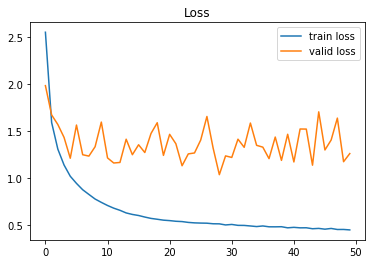

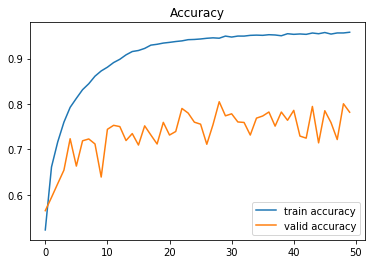

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

- validation accuracy卡住無法再下降
- 應該可嘗試降低learning rate來幫助收斂

### 再次訓練
- 使用原本的model和已經訓練好的weight
- 降低learning rate幫助收斂
- 增加augmentaion

In [9]:
# 降低learning rate

# 若重開時需先load_model
# keras.models.load_model('model_20190805.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# 建立ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [12]:
batch_size = 100

model.fit_generator(data_generator.flow(x_train, y_train, batch_size), 
                    epochs=10, 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    verbose=1, 
                    validation_data=(x_test, y_test))

Epoch 1/10
500/500 [==============================] - 231s 462ms/step - loss: 1.3360 - acc: 0.7421 - val_loss: 1.1752 - val_acc: 0.8150
Epoch 2/10
500/500 [==============================] - 201s 401ms/step - loss: 1.2149 - acc: 0.7636 - val_loss: 1.1410 - val_acc: 0.8183
Epoch 3/10
500/500 [==============================] - 201s 402ms/step - loss: 1.1613 - acc: 0.7693 - val_loss: 1.0982 - val_acc: 0.8226
Epoch 4/10
500/500 [==============================] - 201s 401ms/step - loss: 1.1198 - acc: 0.7774 - val_loss: 1.0767 - val_acc: 0.8243
Epoch 5/10
500/500 [==============================] - 201s 401ms/step - loss: 1.0826 - acc: 0.7793 - val_loss: 1.0629 - val_acc: 0.8249
Epoch 6/10
500/500 [==============================] - 201s 402ms/step - loss: 1.0571 - acc: 0.7866 - val_loss: 1.0365 - val_acc: 0.8282
Epoch 7/10
500/500 [==============================] - 201s 402ms/step - loss: 1.0363 - acc: 0.7904 - val_loss: 1.0111 - val_acc: 0.8293
Epoch 8/10
500/500 [============================

In [13]:
# 儲存model
model.save('model_2nd.h5')

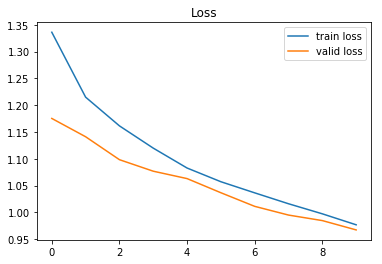

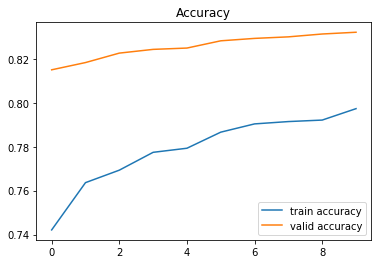

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

- 效果好，且仍然有相當的進步空間
- 加入early-stop繼續訓練。

### 加入early-stop繼續訓練

In [15]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_acc", 
                          patience=5, 
                          verbose=1
                          )

In [16]:
# 若重開時需先load_model
# keras.models.load_model('model_2nd.h5')

model.fit_generator(data_generator.flow(x_train, y_train, batch_size), 
                    epochs=50, 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    verbose=1, 
                    validation_data=(x_test, y_test),
                    callbacks=[earlystop])

Epoch 1/50
500/500 [==============================] - 201s 402ms/step - loss: 0.9750 - acc: 0.7971 - val_loss: 0.9605 - val_acc: 0.8314
Epoch 2/50
500/500 [==============================] - 201s 402ms/step - loss: 0.9533 - acc: 0.8017 - val_loss: 0.9487 - val_acc: 0.8310
Epoch 3/50
500/500 [==============================] - 201s 402ms/step - loss: 0.9403 - acc: 0.8035 - val_loss: 0.9331 - val_acc: 0.8338
Epoch 4/50
500/500 [==============================] - 201s 403ms/step - loss: 0.9334 - acc: 0.8032 - val_loss: 0.9220 - val_acc: 0.8337
Epoch 5/50
500/500 [==============================] - 202s 403ms/step - loss: 0.9198 - acc: 0.8069 - val_loss: 0.9165 - val_acc: 0.8350
Epoch 6/50
500/500 [==============================] - 202s 403ms/step - loss: 0.9166 - acc: 0.8065 - val_loss: 0.9137 - val_acc: 0.8349
Epoch 7/50
500/500 [==============================] - 201s 401ms/step - loss: 0.9095 - acc: 0.8078 - val_loss: 0.9038 - val_acc: 0.8359
Epoch 8/50
500/500 [============================

In [17]:
# 儲存model
model.save('model_3rd.h5')

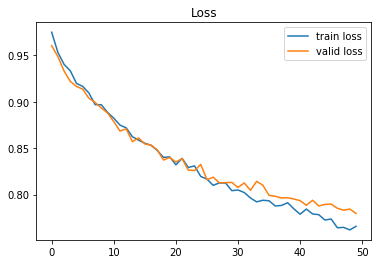

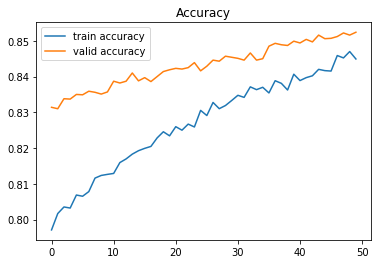

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

- 50個epoch走完依然持續改善，可以繼續訓練

### 調整Learning Rate繼續訓練
- 考量模型應還有持續訓練的空間，稍微加大Learning rate，並加入reduce_lr

In [20]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_acc', 
                              patience=5, 
                              verbose=1)

In [21]:
model.fit_generator(data_generator.flow(x_train, y_train, batch_size), 
                    epochs=30, 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    verbose=1, 
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])

Epoch 1/30
500/500 [==============================] - 200s 400ms/step - loss: 0.7578 - acc: 0.8467 - val_loss: 0.7708 - val_acc: 0.8544
Epoch 2/30
500/500 [==============================] - 199s 398ms/step - loss: 0.7570 - acc: 0.8472 - val_loss: 0.7795 - val_acc: 0.8533
Epoch 3/30
500/500 [==============================] - 199s 399ms/step - loss: 0.7543 - acc: 0.8489 - val_loss: 0.7785 - val_acc: 0.8531
Epoch 4/30
500/500 [==============================] - 200s 399ms/step - loss: 0.7552 - acc: 0.8462 - val_loss: 0.7716 - val_acc: 0.8548
Epoch 5/30
500/500 [==============================] - 199s 399ms/step - loss: 0.7520 - acc: 0.8474 - val_loss: 0.7738 - val_acc: 0.8538
Epoch 6/30
500/500 [==============================] - 199s 398ms/step - loss: 0.7446 - acc: 0.8503 - val_loss: 0.7703 - val_acc: 0.8548
Epoch 7/30
500/500 [==============================] - 199s 399ms/step - loss: 0.7469 - acc: 0.8476 - val_loss: 0.7716 - val_acc: 0.8549
Epoch 8/30
500/500 [============================

In [22]:
# 儲存model
model.save('model_4th.h5')

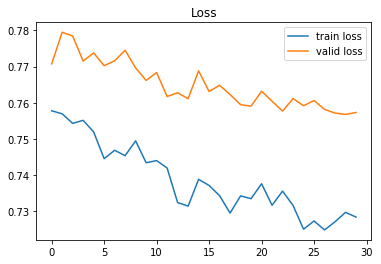

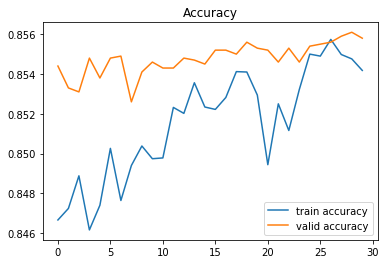

In [23]:
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

- 期間已兩次下降learning rate
- 最終結果: validation accuracy = 0.8558